<a href="https://colab.research.google.com/github/EsmeBarker/Collab/blob/main/EsmeBarkU6proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.9/218.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 10.1 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import bambi as bmb
import pymc as pm
import seaborn as sns
import graphviz as gv

For this project, I took data from the 2022-2023 school year reporting on the performance of public schools across Texas. I wanted to see if it was possible to use factors like District or % of Economically Disadvantaged students to predict school performance.

In [6]:
schools = pd.read_csv("https://raw.githubusercontent.com/EsmeBarker/Collab/refs/heads/main/School_Year_2022-2023_Statewide_Accountability_Ratings.csv")

In [ ]:
schools.District

0              CAYUGA ISD
1              CAYUGA ISD
2              CAYUGA ISD
3              CAYUGA ISD
4             ELKHART ISD
               ...       
10248    CRYSTAL CITY ISD
10249    CRYSTAL CITY ISD
10250        LA PRYOR ISD
10251        LA PRYOR ISD
10252        LA PRYOR ISD
Name: District, Length: 10253, dtype: object

There were lots of different columns in this data, but I was only really interested in a few. The data had to be fixed a bit so I was able to actually create a model with the data I had.

In [7]:
#A bunch of data wrangling stuff that I had gemeni do for me:

# Make a copy of the schools DataFrame to work with locally in this cell
schools_model_data = schools.copy()

# More robust column renaming to handle potential issues with special characters like '\n'
new_columns = schools_model_data.columns.tolist()

# Define the mapping for problematic column names to their desired cleaned versions
rename_mapping = {
    "Grades\nServed": "GradesServed",
    "Overall\nScore": "OverallScore",
    "Number of\nStudents": "NumberofStudents",
    "%\nEconomically\nDisadvantaged": "pEconomicallyDisadvantaged",
    "% EB/EL\nStudents": "pEB_ELStudents", "Public\nEducation\nGrant": "PublicEducationGrant" # Corrected key to match actual column name with newline
}

# Apply the renaming
for i, col in enumerate(new_columns):
    if col in rename_mapping:
        new_columns[i] = rename_mapping[col]
schools_model_data.columns = new_columns

# Apply the filtering, as intended by the previous (unexecuted) cell
schools_model_data = schools_model_data.query('GradesServed == "09 - 12"')

# Clean and convert 'pEconomicallyDisadvantaged' to numeric
schools_model_data['pEconomicallyDisadvantaged'] = (
    schools_model_data['pEconomicallyDisadvantaged']
    .astype(str)
    .str.replace('%', '', regex=False) # Remove '%' character
)
schools_model_data['pEconomicallyDisadvantaged'] = pd.to_numeric(schools_model_data['pEconomicallyDisadvantaged'], errors='coerce')

# Clean and convert 'pEB_ELStudents' to numeric
schools_model_data['pEB_ELStudents'] = (
    schools_model_data['pEB_ELStudents']
    .astype(str)
    .str.replace('%', '', regex=False) # Remove '%' character
)
schools_model_data['pEB_ELStudents'] = pd.to_numeric(schools_model_data['pEB_ELStudents'], errors='coerce')

# Convert 'NumberofStudents' to numeric
schools_model_data['NumberofStudents'] = pd.to_numeric(schools_model_data['NumberofStudents'], errors='coerce')

# Convert 'OverallScore' to numeric
schools_model_data['OverallScore'] = pd.to_numeric(schools_model_data['OverallScore'], errors='coerce')

# Replace NaN values in 'PublicEducationGrant' with False
schools_model_data['PublicEducationGrant'].fillna(False, inplace=True)

# Drop rows where 'OverallScore', 'pEconomicallyDisadvantaged', 'pEB_ELStudents', or 'NumberofStudents' are NaN
schools_model_data.dropna(subset=['OverallScore', 'pEconomicallyDisadvantaged', 'pEB_ELStudents', 'NumberofStudents'], inplace=True)

/tmp/ipython-input-945370740.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  schools_model_data['PublicEducationGrant'].fillna(False, inplace=True)
/tmp/ipython-input-945370740.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  schools_model_data['PublicEducationGrant'].fillna(False, inplace=True)


The pairplot showed that some relationships were pretty random, but there were definitely some that showed patterns that I might be able to use.

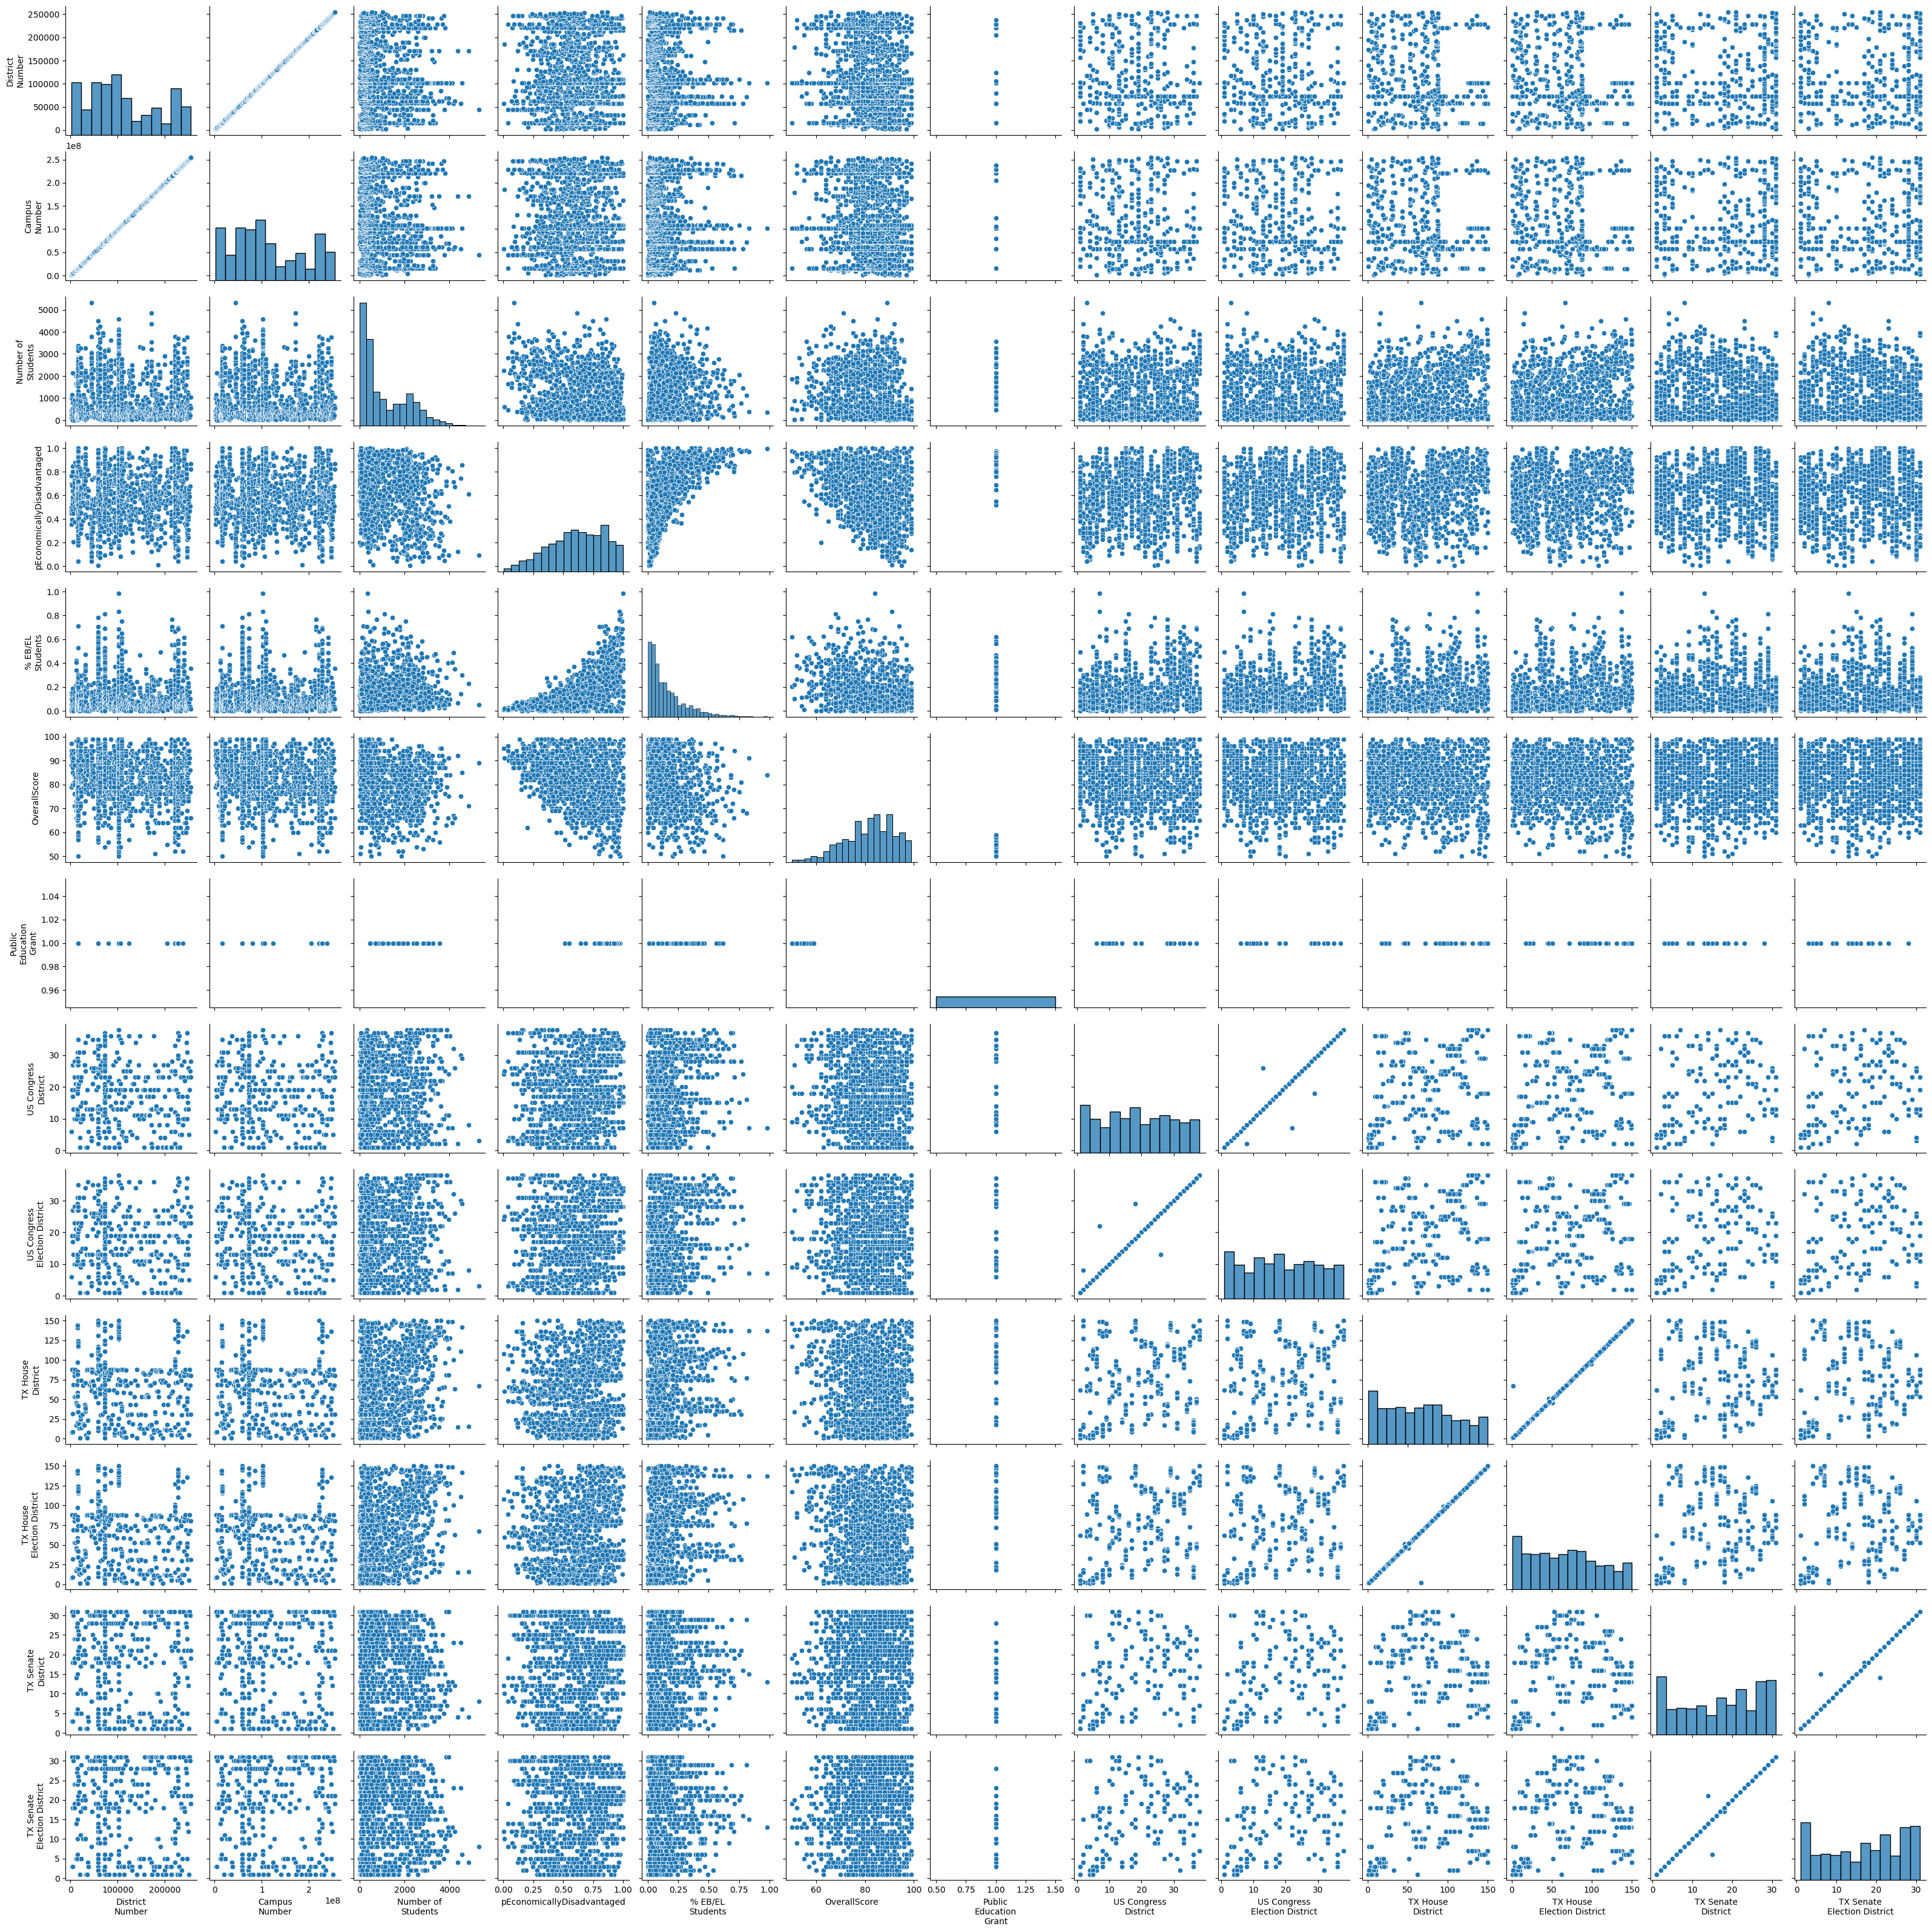

In [ ]:
sns.pairplot(schools_model_data)

I created a visualization of the factors I think probably go into school performance, which mostly seemed like location and economic factors

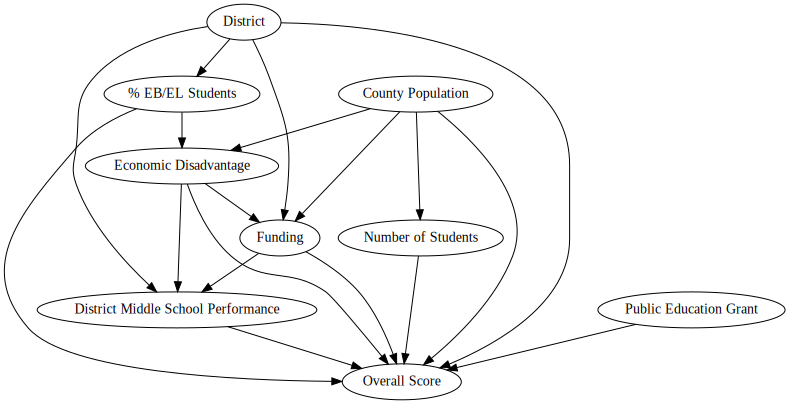

In [ ]:
cd=gv.Digraph(comment='schools')
cd.node('S', 'Overall Score')
cd.node('E', 'Economic Disadvantage')
cd.node('D','District')
cd.node('N','Number of Students')
cd.node('B', '% EB/EL Students')
cd.node('F', 'Funding')
cd.node('P', 'County Population')
cd.node('M', 'District Middle School Performance')
cd.node('G', 'Public Education Grant')
cd.edges([
    ('E',"S"),
    ('D',"S"),
    ('N',"S"),
    ('B',"S"),
    ('F',"S"),
    ('P',"S"),
    ('M',"S"),
    ('E','F'),
    ('D','F'),
    ('P','N'),
    ('P','F'),
    ('B','E'),
    ('F','M'),
    ('D','M'),
    ('E','M'),
    ('P','E'),
    ('D','B'),
    ('G', 'S'),
])
cd

Using this, I made my first model, using all of the factors with an interaction between the percentage of economically disadvantaged students and the percentge of emergent bilingual students.

In [8]:
#Gemeni suggested treating district as a random intercept if I wanted to factor it in, since there are over 700
model_c = bmb.Model("OverallScore ~ pEconomicallyDisadvantaged + PublicEducationGrant + NumberofStudents + pEB_ELStudents + (1|District) + pEB_ELStudents:pEconomicallyDisadvantaged", data=schools_model_data)

In [ ]:
idata_schools_c = model_c.fit(idata_kwargs={'log_likelihood': True})

Looking at some actual visualizations of this model, it is not performing very well. The data across the variables I chose is just pretty scattered, there's not a super clear trend for the model to follow.

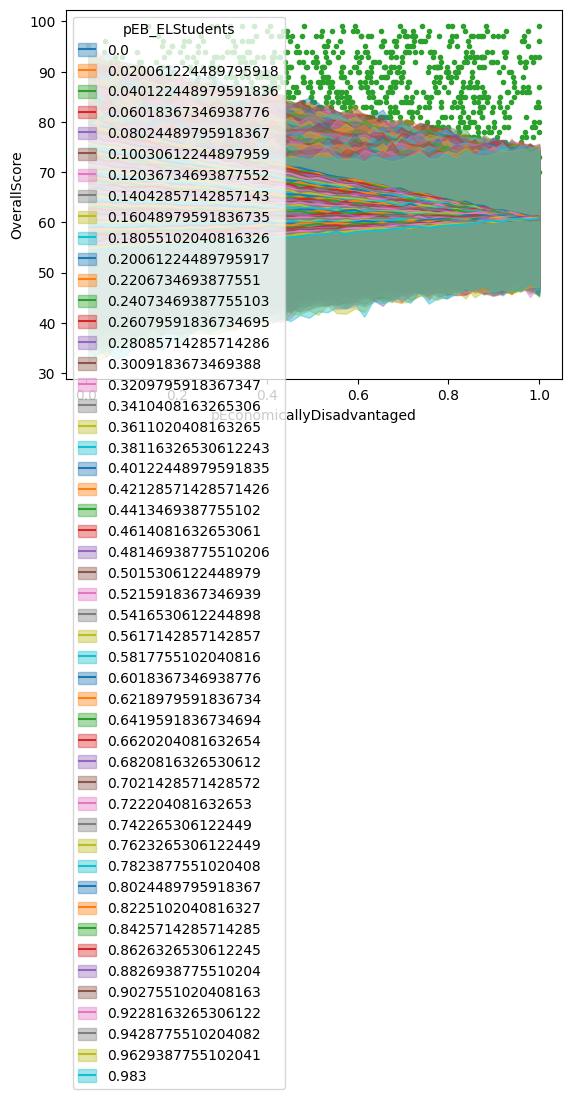

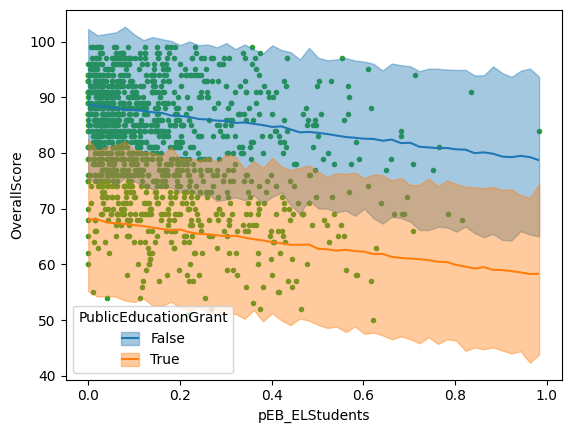

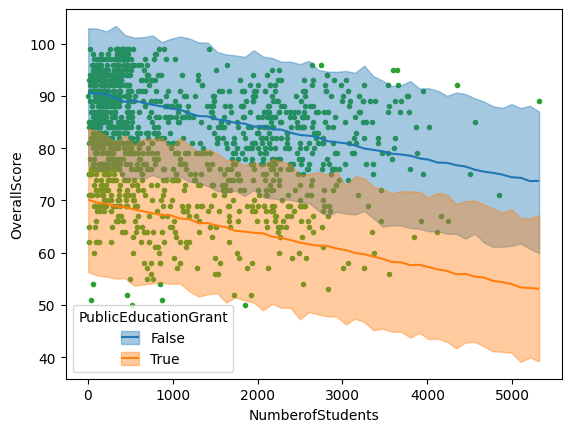

In [28]:
bmb.interpret.plot_predictions(model_c, idata_schools_c, conditional=["pEconomicallyDisadvantaged","pEB_ELStudents"], pps=True)
plt.plot(schools_model_data.pEconomicallyDisadvantaged,schools_model_data.OverallScore,"C2.", zorder=-3)
bmb.interpret.plot_predictions(model_c, idata_schools_c, conditional=["pEB_ELStudents","PublicEducationGrant"], pps=True)
plt.plot(schools_model_data.pEB_ELStudents,schools_model_data.OverallScore,"C2.", zorder=-3)
bmb.interpret.plot_predictions(model_c, idata_schools_c, conditional=["NumberofStudents","PublicEducationGrant"], pps=True)
plt.plot(schools_model_data.NumberofStudents,schools_model_data.OverallScore,"C2.", zorder=-3)

Next, I made a reference model using as many variables and interactions as possible

In [10]:
model_r = bmb.Model("OverallScore ~ pEconomicallyDisadvantaged + PublicEducationGrant + NumberofStudents + pEB_ELStudents + (1|District) + pEB_ELStudents:pEconomicallyDisadvantaged + NumberofStudents:pEB_ELStudents + NumberofStudents:pEconomicallyDisadvantaged + NumberofStudents:PublicEducationGrant + pEB_ELStudents:PublicEducationGrant + pEconomicallyDisadvantaged:PublicEducationGrant", data=schools_model_data)

In [ ]:
idata_schools_r = model_r.fit(idata_kwargs={'log_likelihood': True})

This looked about the same. It makes intuitive sense that these variables would affect school performance, but I'm having trouble finding a good relationship

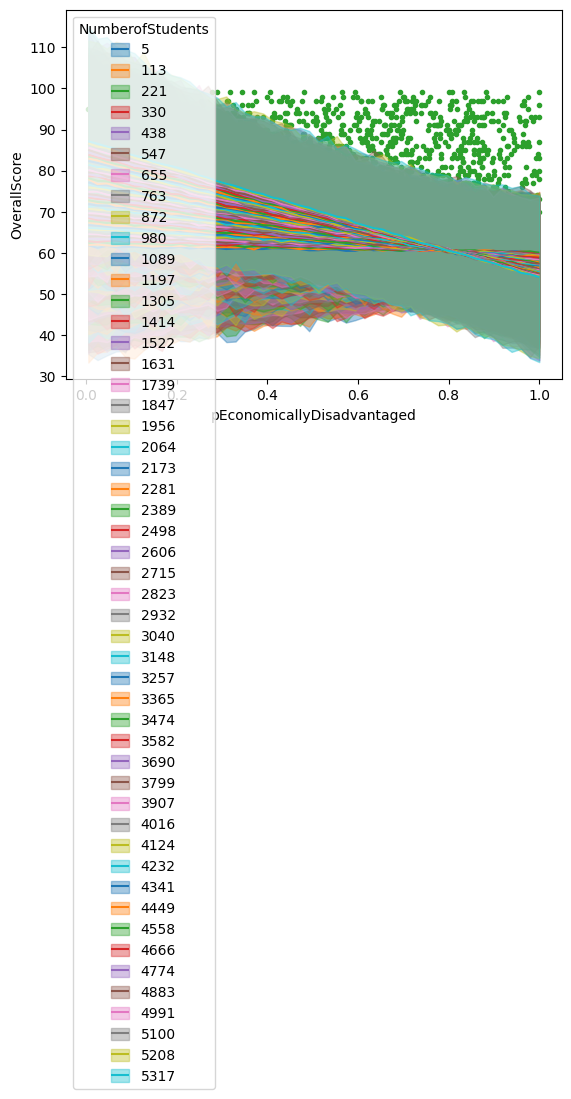

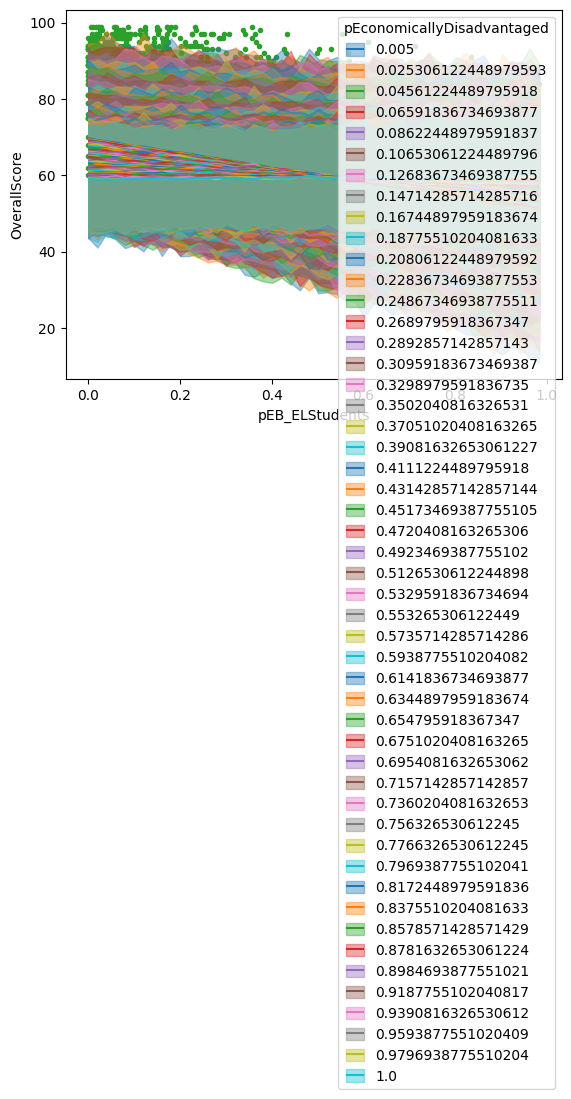

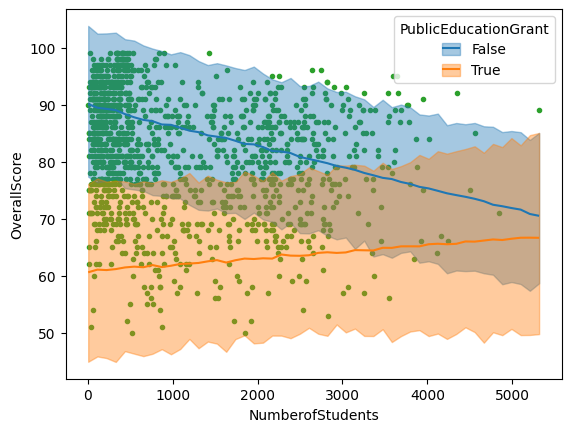

In [ ]:
bmb.interpret.plot_predictions(model_r, idata_schools_r, conditional=["pEconomicallyDisadvantaged", "NumberofStudents"], pps=True)
plt.plot(schools_model_data.pEconomicallyDisadvantaged,schools_model_data.OverallScore,"C2.", zorder=-3)
bmb.interpret.plot_predictions(model_r, idata_schools_r, conditional=["pEB_ELStudents", "pEconomicallyDisadvantaged"], pps=True)
plt.plot(schools_model_data.pEB_ELStudents,schools_model_data.OverallScore,"C2.", zorder=-3)
bmb.interpret.plot_predictions(model_r, idata_schools_r, conditional=["NumberofStudents", "PublicEducationGrant"], pps=True)
plt.plot(schools_model_data.NumberofStudents,schools_model_data.OverallScore,"C2.", zorder=-3)

In [ ]:
cmp_df = az.compare( {"casual":idata_schools_c,"reference":idata_schools_r} )

The elpd_loo at least looks significantly better for the reference model, so I can use that to make the best model I can with this data.

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

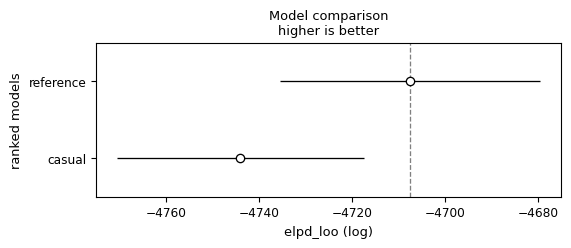

In [ ]:
az.plot_compare(cmp_df)

After that I just made a bunch of different models, taking out one varibale at a time to see if one was having a bigger impact.

In [ ]:
model_nn = bmb.Model("OverallScore ~ pEconomicallyDisadvantaged + PublicEducationGrant + pEB_ELStudents + (1|District) + pEB_ELStudents:pEconomicallyDisadvantaged + pEB_ELStudents:PublicEducationGrant + pEconomicallyDisadvantaged:PublicEducationGrant", data=schools_model_data)

In [ ]:
idata_schools_nn = model_nn.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
model_nd = bmb.Model("OverallScore ~ PublicEducationGrant + NumberofStudents + pEB_ELStudents + (1|District) + NumberofStudents:pEB_ELStudents + NumberofStudents:PublicEducationGrant + pEB_ELStudents:PublicEducationGrant", data=schools_model_data)

In [ ]:
idata_schools_nd = model_nd.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
model_np = bmb.Model("OverallScore ~ pEconomicallyDisadvantaged + NumberofStudents + pEB_ELStudents + (1|District) + pEB_ELStudents:pEconomicallyDisadvantaged + NumberofStudents:pEB_ELStudents + NumberofStudents:pEconomicallyDisadvantaged", data=schools_model_data)

In [ ]:
idata_schools_np = model_nd.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
model_ns = bmb.Model("OverallScore ~ pEconomicallyDisadvantaged + PublicEducationGrant + NumberofStudents + (1|District) + NumberofStudents:pEconomicallyDisadvantaged + NumberofStudents:PublicEducationGrant + pEconomicallyDisadvantaged:PublicEducationGrant", data=schools_model_data)

In [ ]:
idata_schools_ns = model_nd.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
model_nr= bmb.Model("OverallScore ~ pEconomicallyDisadvantaged + PublicEducationGrant + NumberofStudents + pEB_ELStudents + (1|District)", data=schools_model_data)

In [ ]:
idata_schools_nr = model_nr.fit(idata_kwargs={'log_likelihood': True})

After doing this it looked like the "Number of Students" variable had a significantly bigger impact than any of the other ones, so I made a model that only used interactions with that variable, and then a few more that took them away.

In [12]:
model_on = bmb.Model("OverallScore ~ pEconomicallyDisadvantaged + PublicEducationGrant + NumberofStudents + pEB_ELStudents + (1|District) + NumberofStudents:pEconomicallyDisadvantaged + NumberofStudents:PublicEducationGrant + NumberofStudents:pEB_ELStudents", data=schools_model_data)

In [ ]:
idata_schools_on = model_on.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
model_onnnp= bmb.Model("OverallScore ~ pEconomicallyDisadvantaged + PublicEducationGrant + NumberofStudents + pEB_ELStudents + (1|District) + NumberofStudents:pEconomicallyDisadvantaged + NumberofStudents:pEB_ELStudents", data=schools_model_data)

In [ ]:
idata_schools_onnnp = model_onnnp.fit(idata_kwargs={'log_likelihood': True})

In [25]:
model_onnns = bmb.Model("OverallScore ~ pEconomicallyDisadvantaged + PublicEducationGrant + NumberofStudents + pEB_ELStudents + (1|District) + NumberofStudents:pEconomicallyDisadvantaged + NumberofStudents:PublicEducationGrant", data=schools_model_data)

In [ ]:
idata_schools_onnns = model_onnns.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
cmp_df = az.compare( {"on": idata_schools_on, "onnnp": idata_schools_onnnp, "onnns": idata_schools_onnns, "casual":idata_schools_c,"reference":idata_schools_r,"ns":idata_schools_ns, "np":idata_schools_np,"nn":idata_schools_nn, "nd":idata_schools_nd,  "nr":idata_schools_nr} )

As you can see here, only using interactions with the number of students while keeping all other variables has about the same elpd_loo as the reference, actually a little bit better. Taking away more interactions after that didn't change things much, just made the model slightly worse.

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

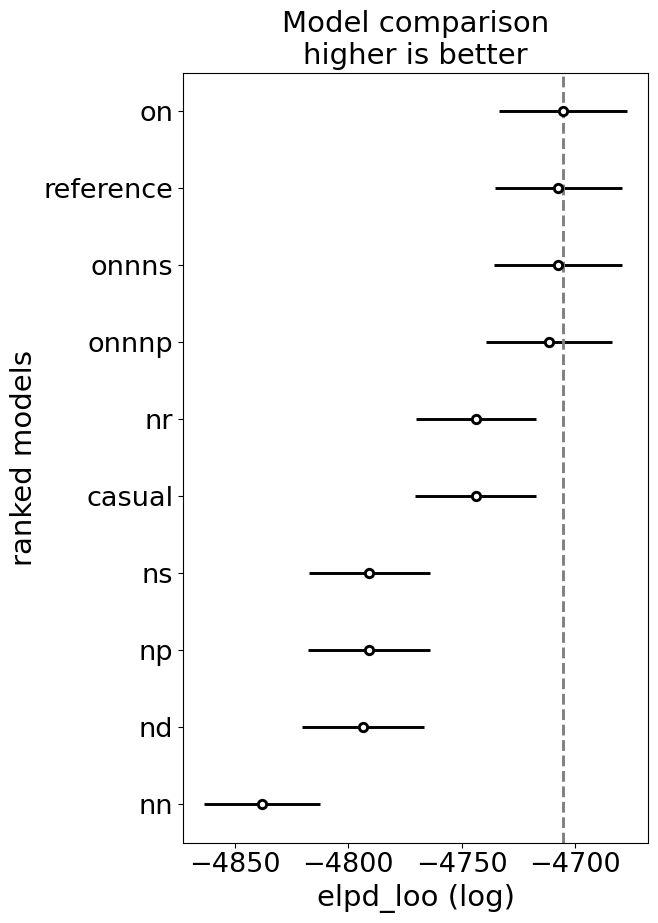

In [ ]:
az.plot_compare(cmp_df)

Comparing some of the top models looking at the overall score vs number of students with different values for the public education grant, since that's the only one that's really readable, they all still look about the same.

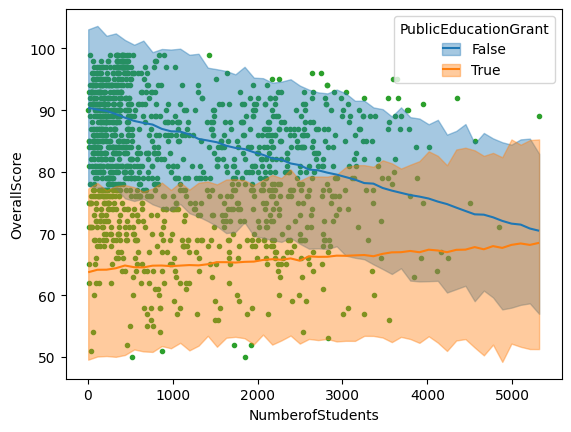

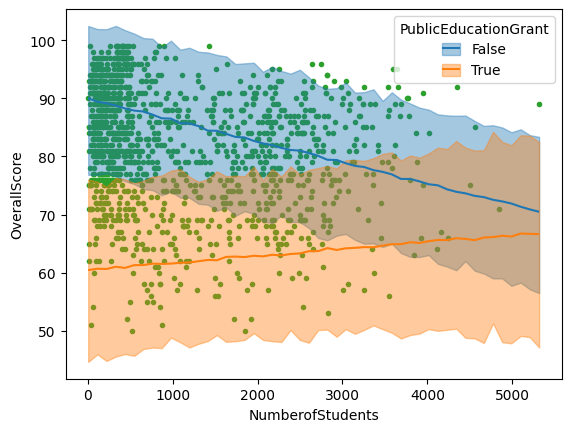

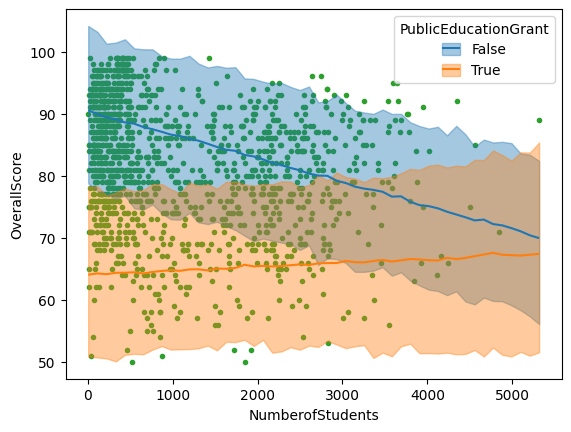

In [27]:
bmb.interpret.plot_predictions(model_on, idata_schools_on, conditional=["NumberofStudents","PublicEducationGrant"], pps=True)
plt.plot(schools_model_data.NumberofStudents,schools_model_data.OverallScore,"C2.", zorder=-3)
bmb.interpret.plot_predictions(model_r, idata_schools_r, conditional=["NumberofStudents", "PublicEducationGrant"], pps=True)
plt.plot(schools_model_data.NumberofStudents,schools_model_data.OverallScore,"C2.", zorder=-3)
bmb.interpret.plot_predictions(model_onnns, idata_schools_onnns, conditional=["NumberofStudents","PublicEducationGrant"], pps=True)
plt.plot(schools_model_data.NumberofStudents,schools_model_data.OverallScore,"C2.", zorder=-3)

Since the visualizations all look the same, it makes sense to me to just choose the model that had a high elpd_loo value without many variables, and I think the best one is "model_on".

Really, there just wasn't much of a good way to predict overall score. All of these models just don't work well. It is really hard to imagine that these factors do not play a role in the performance of a school, so I feel like this must've either not have been a very good dataset or there was something happening that I didn't understand.